# Reproduction of ELS learning curves in Bandit Task

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
import importlib
from sklearn import metrics
import pickle

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
# my models
import opal
from opal import OpAL
import learning
import plot_dynamics

In [2]:
importlib.reload(plot_dynamics)

<module 'plot_dynamics' from '/Users/ajaskir/Desktop/FYP/opal/notebooks/../plot_dynamics.py'>

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))

/var/folders/x1/w7n6h7cn2z17zbtntm879lcw0000gp/T/ipykernel_58820/3291590995.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [13]:
# Helper Functions # --------------------------------------------------------------------
def avg_WinShift(states,n_trials,n_states):
  
  avg_stays = np.zeros((n_states,1))
  for idx,s in enumerate(states):
    wins = np.where(s.R == 1)[0] # win trial
    nextT = wins + 1 # next trial
    if len(wins) == 0:
        continue
    # if the last trial was a win, ignore, no choice after last trial
    if nextT[-1] == n_trials:
      wins = wins[:-1]
      nextT = nextT[:-1]
    avg_stays[idx] = np.sum(s.C[wins] != s.C[nextT])/len(wins) # shape: state x fraction

  return (np.nanmean(avg_stays,axis=0), stats.sem(avg_stays,axis=0,nan_policy="omit"))

def avg_LoseShift(states,n_trials,n_states):
  
  avg_stays = np.zeros((n_states,1)) 
  for idx,s in enumerate(states):
    wins = np.where(s.R == 0)[0] # win trial
    nextT = wins + 1 # next trial
    if len(wins) == 0:
        continue
    # if the last trial was a win, ignore, no choice after last trial
    if nextT[-1] == n_trials:
      wins = wins[:-1]
      nextT = nextT[:-1]
    avg_stays[idx] = np.sum(s.C[wins] != s.C[nextT])/len(wins) # shape: state x fraction

  return (np.nanmean(avg_stays,axis=0), stats.sem(avg_stays,axis=0,nan_policy="omit"))

def avg_WinStay(states,n_trials,n_states):
  
  avg_stays = np.zeros((n_states,1)) 
  for idx,s in enumerate(states):
    wins = np.where(s.R == 1)[0] # win trial
    nextT = wins + 1 # next trial
    if len(wins) == 0:
        continue
    # if the last trial was a win, ignore, no choice after last trial
    if nextT[-1] == n_trials:
      wins = wins[:-1]
      nextT = nextT[:-1]
    avg_stays[idx] = np.sum(s.C[wins] == s.C[nextT])/len(wins) # shape: state x fraction

  return (np.nanmean(avg_stays,axis=0), stats.sem(avg_stays,axis=0,nan_policy="omit"))

def avg_LoseStay(states,n_trials,n_states):
  
  avg_stays = np.zeros((n_states,1))
  for idx,s in enumerate(states):
    wins = np.where(s.R == 0)[0] # win trial
    nextT = wins + 1 # next trial
    if len(wins) == 0:
        continue
    # if the last trial was a win, ignore, no choice after last trial
    if nextT[-1] == n_trials:
      wins = wins[:-1]
      nextT = nextT[:-1]
    avg_stays[idx] = np.sum(s.C[wins] == s.C[nextT])/len(wins) # shape: state x fraction

  return (np.nanmean(avg_stays,axis=0), stats.sem(avg_stays,axis=0,nan_policy="omit"))

# Helper Functions # --------------------------------------------------------------------
def avg_WinShift_BLOCKED(states,n_trials,n_states):
  
  avg_stays = np.zeros((n_states,6)) + np.NaN #divide into 6 blocks of 5 trials
  for idx,s in enumerate(states):
    for progress,i in enumerate(np.arange(0,n_trials,5)):
      endInd = i + 4 
      wins = np.where(s.R[i:endInd] == 1)[0] # win trials
      nextT = wins + 1 # next trial
      if len(wins) == 0:
        continue
      # if the last trial was a win, ignore, no choice after last trial
      if nextT[-1] == n_trials:
        wins = wins[:-1]
        nextT = nextT[:-1]
      avg_stays[idx,progress] = np.mean(s.C[wins] != s.C[nextT]) # shape: state x fraction

  return np.nanmean(avg_stays,axis=0)

def avg_LoseShift_BLOCKED(states,n_trials,n_states):
  
  avg_stays = np.zeros((n_states,6)) + np.NaN #divide into 6 blocks of 5 trials
  for idx,s in enumerate(states):
    for progress,i in enumerate(np.arange(0,n_trials,5)):
      endInd = i + 4 
      wins = np.where(s.R[i:endInd] == 0)[0] # lose trials
      nextT = wins + 1 # next trial
      if len(wins) == 0:
        continue
      # if the last trial was a lose, ignore, no choice after last trial
      if nextT[-1] == n_trials:
        wins = wins[:-1]
        nextT = nextT[:-1]
      avg_stays[idx,progress] = np.mean(s.C[wins] != s.C[nextT]) # shape: state x fraction

  return np.nanmean(avg_stays,axis=0)

def avg_WinStay_BLOCKED(states,n_trials,n_states):
  
  avg_stays = np.zeros((n_states,6)) + np.NaN #divide into 6 blocks of 5 trials
  for idx,s in enumerate(states):
    for progress,i in enumerate(np.arange(0,n_trials,5)):
      endInd = i + 4 
      wins = np.where(s.R[i:endInd] == 1)[0] # win trials
      nextT = wins + 1 # next trial
      if len(wins) == 0:
        continue
      # if the last trial was a win, ignore, no choice after last trial
      if nextT[-1] == n_trials:
        wins = wins[:-1]
        nextT = nextT[:-1]
      avg_stays[idx,progress] = np.mean(s.C[wins] == s.C[nextT]) # shape: state x fraction

  return np.nanmean(avg_stays,axis=0)

def avg_LoseStay_BLOCKED(states,n_trials,n_states):
  
  avg_stays = np.zeros((n_states,6)) + np.NaN #divide into 6 blocks of 5 trials
  for idx,s in enumerate(states):
    for progress,i in enumerate(np.arange(0,n_trials,5)):
      endInd = i + 4 
      wins = np.where(s.R[i:endInd] == 0)[0] # lose trials
      nextT = wins + 1 # next trial
      if len(wins) == 0:
        continue
      # if the last trial was a lose, ignore, no choice after last trial
      if nextT[-1] == n_trials:
        wins = wins[:-1]
        nextT = nextT[:-1]
      avg_stays[idx,progress] = np.mean(s.C[wins] == s.C[nextT]) # shape: state x fraction

  return np.nanmean(avg_stays,axis=0)

In [5]:
# initialize parameters

# optimized for no modulation (Bayes)
alpha_c = 0.23   # not actually used with any Bayes critics
alpha_a = 0.28   # learning rate
beta =  5     # softmax temp
params = (alpha_c,alpha_a, beta)

crit = "SA" # Use "SA" for standard RL critic
mod = "constant" # Uses uncertainty (std of Bayes dist) to determine when to modulate DA 

rho = .035

# reward mag and loss mag
# same for each
r_mag = 1
l_mag = 0
if crit == "Bayes-SA":
    v0 = np.array([0.,0.]) #prior for number of wins/losses expected 
else:
    v0 = 0.5*r_mag + .5*l_mag 

# normalize by magnitude
norm = False
mag = r_mag - l_mag

# anneal learning rate?
anneal = False
T = 10.0

# modify when phi*std of distribution sufficiently above/below 50%
# think of as "confidence" in values before modulating dopamine
phi = 1.0  
use_std = False
exp_val = False
k=1

# misc plotting things
print_auc = False
plt.rcParams.update({'font.size': 22})

In [6]:
# Task design # --------------------------------------------------------------------
# env structure: X_Y_Z - 
# X is the P(reward) of the best option
# Y is the difference between the P(reward) of best and worst option
# Z is the number of options

env1 = "90_80_2" # 90-80 = 10% is the other option
env2 = "90_40_2" # 90-40 = 50% is the other option
env3 = "50_40_2" # 10% is the other option
env4 = "50_0_2"  # equal
envs = [env1,env2,env3,env4]
label = ["90:10", "90:50", "50:10", "50:50", "ELS 90:10", "ELS 90:50", "ELS 50:10", "ELS 50:50"] # for legend
colors_ELA = {env1:"steelblue", env2:"lightgreen", env3:"lightblue", env4:"grey"}
colors = {env1:"blue", env2:"lime", env3:"cyan", env4:"black"}
all_colors = {"90:10":"blue", "90:50":"lime", "50:10":"cyan", "50:50":"black", "ELS 90:10":"steelblue", "ELS 90:50":"lightgreen", "ELS 50:10":"lightblue", "ELS 50:50":"grey"}


ntrials = 30 # technically random between 25-35, 30 here for simplicity
nmice = 250 #250

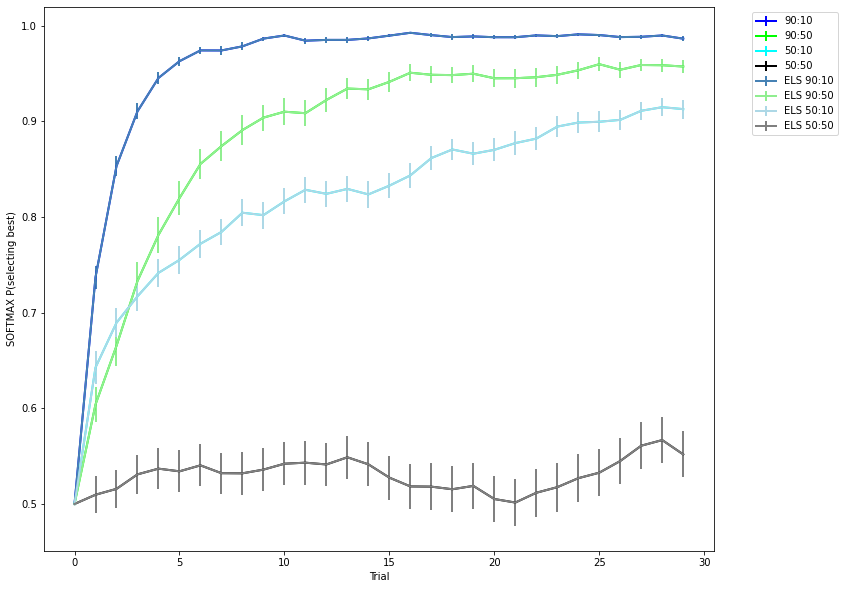

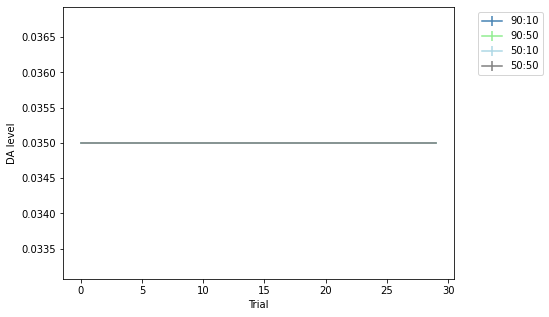

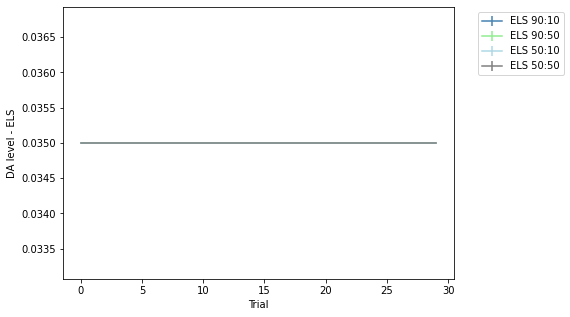

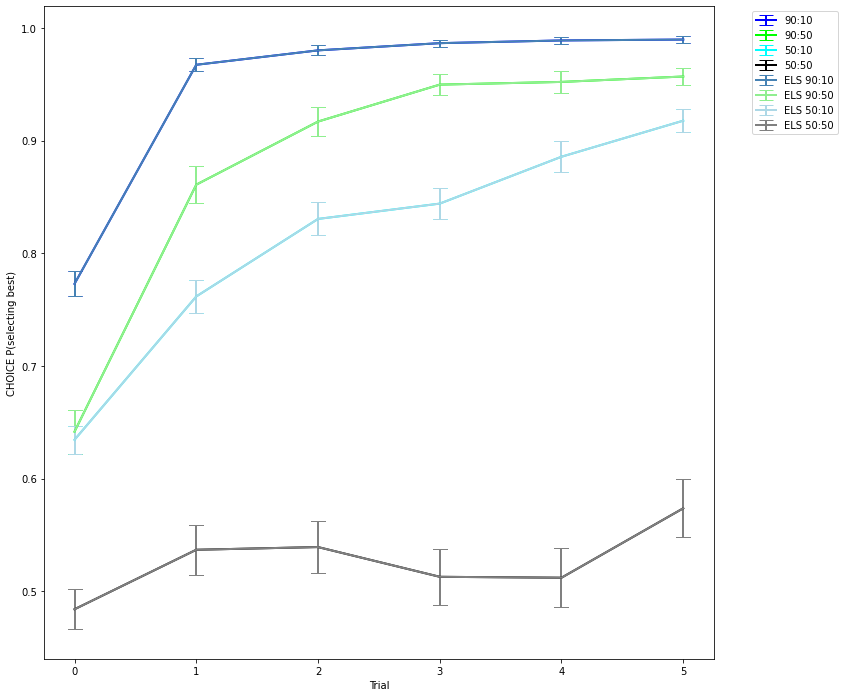

In [7]:
# Prep things # -----------------------------------------------------------------------

# plotting things
fig_sm, ax_sm = plt.subplots(figsize=(12, 10))
plt.ylabel("SOFTMAX P(selecting best)") # softmax p(action)
plt.xlabel("Trial")

fig_rho, ax_rho = plt.subplots(figsize=(7, 5)) # rho
plt.ylabel("DA level")
plt.xlabel("Trial")

fig_rho, ax_rhoELS = plt.subplots(figsize=(7, 5)) # rho
plt.ylabel("DA level - ELS")
plt.xlabel("Trial")

fig_choice, ax_choice = plt.subplots(figsize=(12, 12))
plt.ylabel("CHOICE P(selecting best)") # behavior
plt.xlabel("Trial")

# generate new random seeds for simulation?
new_seeds = True
if new_seeds:
    res = {}
    rnd_seeds = np.random.randint(1,100000,nmice)  

# CONTROL # ----------------------------------------------------------------------------
for idx, env in enumerate(envs):
    this_res = learning.simulate(params,nmice,ntrials,v0=v0,crit=crit,env=env,mod=mod,k=k,norm=norm,mag=mag,anneal=anneal,T=T,phi=phi,r_mag=r_mag,l_mag=l_mag,rnd_seeds=rnd_seeds,rho=rho)
    res[label[idx]] = this_res
    plot_me = res[label[idx]]
    plot_dynamics.avg_sm(plot_me,ntrials,nmice,0,ax_sm,colors[env],print_auc=print_auc)
    plot_dynamics.avg_rho(plot_me,ntrials,nmice,ax_rho,color=colors_ELA[env])
    plot_dynamics.avg_choice(plot_me,ntrials,nmice,0,ax_choice,colors[env],print_auc=print_auc,chunk=True)

# ELS # ----------------------------------------------------------------------------
for idx, env in enumerate(envs):
    this_res = learning.simulate(params,nmice,ntrials,v0=v0,crit=crit,env=env,mod=mod,k=k,norm=norm,mag=mag,anneal=anneal,T=T,phi=phi,r_mag=r_mag,l_mag=l_mag,rnd_seeds=rnd_seeds,rho=rho)
    res[label[idx + 4]] = this_res
    plot_me = res[label[idx + 4]]
    plot_dynamics.avg_sm(plot_me,ntrials,nmice,0,ax_sm,colors_ELA[env],print_auc=print_auc)
    plot_dynamics.avg_rho(plot_me,ntrials,nmice,ax_rhoELS,color=colors_ELA[env])
    plot_dynamics.avg_choice(plot_me,ntrials,nmice,0,ax_choice,colors_ELA[env],print_auc=print_auc,chunk=True)

ax_sm.legend(label,bbox_to_anchor=(1.05, 1), loc='upper left')
ax_choice.legend(label,bbox_to_anchor=(1.05, 1), loc='upper left')
ax_rho.legend(label[0:4],bbox_to_anchor=(1.05, 1), loc='upper left')
ax_rhoELS.legend(label[4:],bbox_to_anchor=(1.05, 1), loc='upper left')

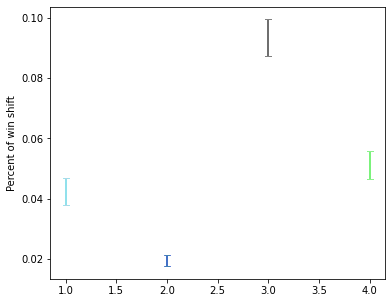

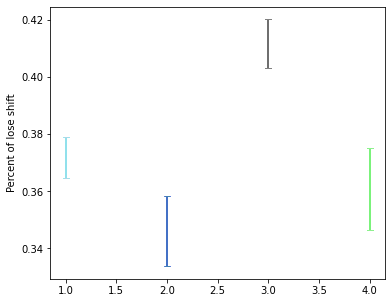

In [14]:
# plot win-shift
fig_WS, ax_WS = plt.subplots(figsize=(6, 5))
plt.ylabel("Percent of win shift") # softmax p(action)

env_to_xaxis = {"90:10":2, "90:50":4, "50:10":1, "50:50":3, "ELS 90:10":2, "ELS 90:50":4, "ELS 50:10":1, "ELS 50:50":3}

nkeys = len(res.keys())
for i in range(nkeys):
  (mean_env, sem_env) = avg_WinShift(res[label[i]],ntrials,nmice)
  ax_WS.errorbar(env_to_xaxis[label[i]],mean_env,yerr=sem_env,color=all_colors[label[i]],capsize=3)

# plot win-shift
fig_LS, ax_LS = plt.subplots(figsize=(6, 5))
plt.ylabel("Percent of lose shift") # softmax p(action)

env_to_xaxis = {"90:10":2, "90:50":4, "50:10":1, "50:50":3, "ELS 90:10":2, "ELS 90:50":4, "ELS 50:10":1, "ELS 50:50":3}

nkeys = len(res.keys())
for i in range(nkeys):
  (mean_env, sem_env) = avg_LoseShift(res[label[i]],ntrials,nmice)
  ax_LS.errorbar(env_to_xaxis[label[i]],mean_env,yerr=sem_env,color=all_colors[label[i]],capsize=3)

In [9]:
importlib.reload(plot_dynamics)
print("90:10")
plot_dynamics.avg_RT(res['90:10'],1,1)
print("ELS")
plot_dynamics.avg_RT(res['ELS 90:10'],1,1)
print("")
print("90:50")
plot_dynamics.avg_RT(res['90:50'],1,1)
print("ELS")
plot_dynamics.avg_RT(res['ELS 90:50'],1,1)
print("")
print("50:10")
plot_dynamics.avg_RT(res['50:10'],1,1)
print("ELS")
plot_dynamics.avg_RT(res['ELS 50:10'],1,1)
print("")
print("50:50")
plot_dynamics.avg_RT(res['50:50'],1,1)
print("ELS")
plot_dynamics.avg_RT(res['ELS 50:50'],1,1)

90:10
1.0767751501378793
ELS
1.0767751501378793

90:50
1.0842548604358693
ELS
1.0842548604358693

50:10
1.4915889472367854
ELS
1.4915889472367854

50:50
1.3966806175854303
ELS
1.3966806175854303


In [10]:
res.keys()

dict_keys(['90:10', '90:50', '50:10', '50:50', 'ELS 90:10', 'ELS 90:50', 'ELS 50:10', 'ELS 50:50'])

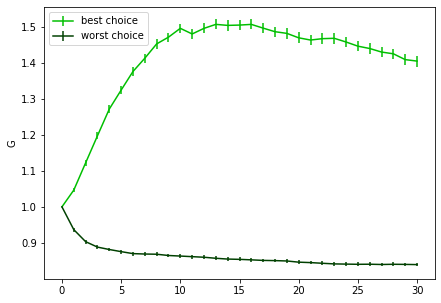

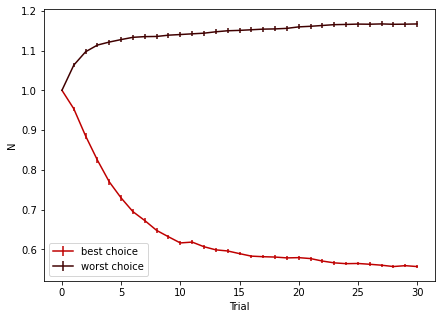

In [11]:
# Plot the G/N (i.e. D1/D2) for the specified simulation
# Options: "90:10", "90:50", "50:10", "50:50", "ELS 90:10", "ELS 90:50", "ELS 50:10", "ELS 50:50"
sim_to_plot = "90:10" # change this to plot different G/N
plot_me = res[sim_to_plot] 

fig1, ax1 = plt.subplots(figsize=(7, 5)) # go
fig2, ax2 = plt.subplots(figsize=(7, 5)) # no go 
axs = [ax1,ax2]
plot_dynamics.avg_qs(plot_me,ntrials,nmice,0,axs,.75)
plot_dynamics.avg_qs(plot_me,ntrials,nmice,1,axs,.25)
ax1.set_ylabel("G")
ax2.set_ylabel("N")
plt.xlabel("Trial")
ax1.legend(["best choice", "worst choice"])
ax2.legend(["best choice", "worst choice"])

In [12]:
# uncomment below to save or load seeds generated above
# pickle.dump([rnd_seeds, ela_rnd_seeds], open("ELS/seedlog3.pkle","wb"))
# rnd_seeds, ela_rnd_seeds = pickle.load(open("ELS/seedlog1.pkle","wb"))